# Deskewing
When working with [single objective light sheet microscopy](https://andrewgyork.github.io/high_na_single_objective_lightsheet/), a special image processing step is necessary to reconstruction spatially corrected image stacks. This processing step is called "deskewing". Since version 0.14.0, pyclesperanto_prototype has a function for that.

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle

cle.get_device()

<Apple M1 Max on Platform: Apple (2 refs)>

In [2]:
original_image = imread('../../data/RBC_tiny.tif')
original_image.shape

(834, 118, 209)

The example image data shown below was kindly provided by 
[Dr George Ashdown](https://au.linkedin.com/in/george-ashdown-33559947?trk=public_post_share-update_update-text) and [Dr Niall Geoghegan](https://uk.linkedin.com/in/niall-geoghegan-72aa2446?trk=public_post_share-update_update-text) from the [WEHI, Melbourne, Australia](https://www.linkedin.com/company/wehi_research?trk=public_post_share-update_actor-text) who used lattice light sheet microscopy to capture immune cells called neutrophils.

In these so called raw data images taken with single-objective light sheet microscopes, the Z-plane is swept through the sample in a tilted way. This is not obvious when studying the Z-planes of the given stack:

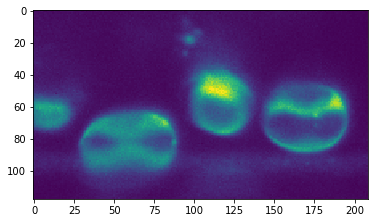

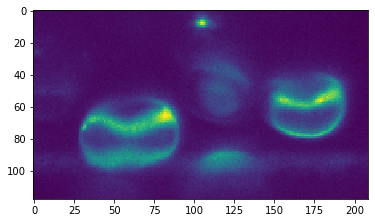

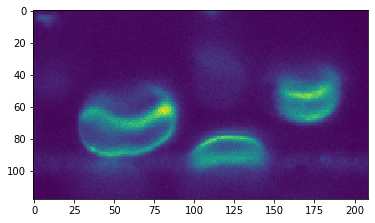

In [3]:
cle.imshow(original_image[0])
cle.imshow(original_image[5])
cle.imshow(original_image[10])

When looking at this image stack from the side, one can see the tilt of the light sheet orientation.

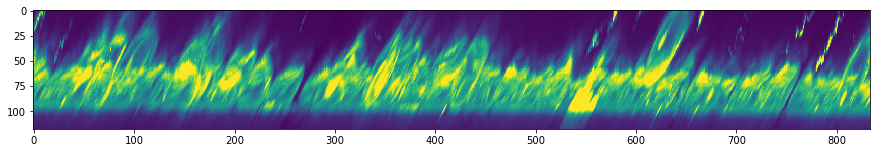

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

cle.imshow(cle.maximum_x_projection(original_image), plot=axs)

## Deskewing in action
Removing this tilt from the raw data is technially a [shearing](https://en.wikipedia.org/wiki/Shear_matrix), which is a rather uncommon part of an [affine transform](https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation).

In pyclesperanto, we have a `deskew_y()` function that takes an input image and the sweep-angle as input:

In [5]:
deskewed = cle.deskew_y(original_image, angle_in_degrees=30)

deskewed.shape

(102, 1022, 209)

The resulting image has a quite different size because the image stack is not just sheared, it is also rotated in a way that the Z-planes of the resulting image stack correspond to an orientation that the Z-axis goes in proximal-distal orientation from the objective. As if we hat acquired an image using a confocal microscope. 

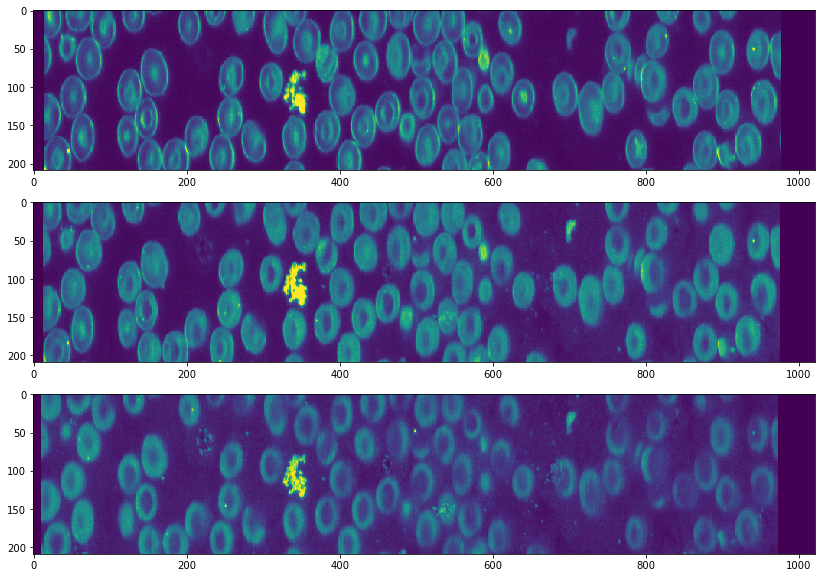

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(30,10))

cle.imshow(deskewed[75].T, plot=axs[0])
cle.imshow(deskewed[80].T, plot=axs[1])
cle.imshow(deskewed[85].T, plot=axs[2])

If we project this stack from the side, we see the deskewed tilt, especially in comparison again the projected original image

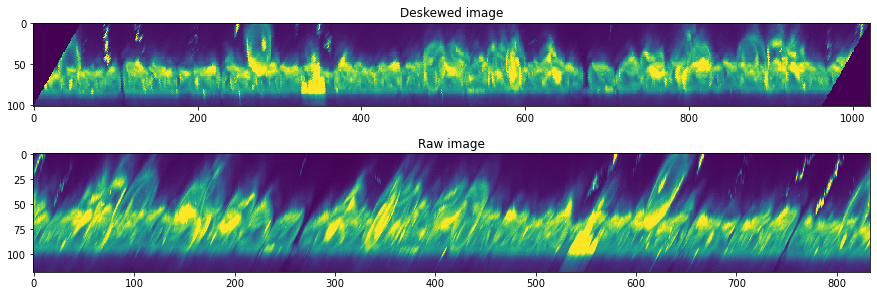

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15,5))

cle.imshow(cle.maximum_x_projection(deskewed).T, plot=axs[0])
axs[0].title.set_text("Deskewed image")
cle.imshow(cle.maximum_x_projection(original_image), plot=axs[1])
axs[1].title.set_text("Raw image")